In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import ParameterGrid
from metrics import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_path = "/content/drive/MyDrive"  
train_data = pd.read_parquet(f"{base_path}/train_dataset_ebnerd_small.parquet")
validation_data = pd.read_parquet(f"{base_path}/val_dataset_ebnerd_small.parquet")
test_data = pd.read_parquet(f"{base_path}/test_dataset_ebnerd_small.parquet")

# Displaying dataset sizes
print(f"Training data size: {len(train_data):,} samples")
print(f"Validation data size: {len(validation_data):,} samples")
print(f"Test data size: {len(test_data):,} samples")


Training data size: 1,882,518 samples
Validation data size: 343,776 samples
Test data size: 359,446 samples


In [ ]:
import pandas as pd
import xgboost as xgb

target = ["clicked"]
ids = ["impression_id", "session_id", "article_id", "user_id"]
excluded_columns = target + ids

# Step 1: Identify categorical columns
categorical_columns = train_data.select_dtypes(include=['object', 'category']).columns.tolist()
feature_list = [col for col in train_data.columns if col not in excluded_columns]

# Step 2: Combine feature_list with categorical_columns to ensure we're encoding them correctly
feature_list = list(set(feature_list + categorical_columns))
print("Features used for modeling:", feature_list)

# Prepare training data
X_train = pd.get_dummies(train_data[feature_list], drop_first=True)
y_train = train_data['clicked'].values
X_train['qid'] = train_data['impression_id'] 

# Prepare validation data
X_val = pd.get_dummies(validation_data[feature_list], drop_first=True)
X_val = X_val.reindex(columns=X_train.columns[:-1], fill_value=0) 
y_val = validation_data['clicked'].values
X_val['qid'] = validation_data['impression_id'] 
# Prepare test data
X_test = pd.get_dummies(test_data[feature_list], drop_first=True)
X_test = X_test.reindex(columns=X_train.columns[:-1], fill_value=0)  
y_test = test_data['clicked'].values
X_test['qid'] = test_data['impression_id']

dtrain = xgb.DMatrix(X_train.drop(columns=['qid']), label=y_train, qid=X_train['qid'])
dval = xgb.DMatrix(X_val.drop(columns=['qid']), label=y_val, qid=X_val['qid'])
dtest = xgb.DMatrix(X_test.drop(columns=['qid']), label=y_test, qid=X_test['qid'])


Features used for modeling: ['is_subscriber', 'origin_scroll_percentage', 'device_type', 'user_article_least_favorite', 'cluster', 'premium', 'origin_current_same_category', 'user_average_scroll_percentage', 'user_mood', 'origin_cluster', 'is_sso_user', 'origin_current_diff_published', 'origin_current_same_cluster', 'origin_sentiment_score', 'origin_current_diff_impression_published', 'user_impression_frequency', 'user_article_same_mood', 'origin_current_diff_sentiment_score', 'origin_sentiment_label', 'sentiment_score', 'time_of_day', 'sentiment_label', 'user_article_favorite', 'coming_from_home_page', 'origin_read_time', 'origin_current_same_sentiment_label', 'user_interaction_score', 'user_average_read_time']


In [29]:
# Custom function to calculate NDCG for each group
def calculate_grouped_ndcg(df, k=3, id = "impression_id"):
    ndcg_scores = []
    for qid, group in df.groupby(id):
        ndcg_scores.append(calculate_ndcg(group, k))
    return np.mean(ndcg_scores)

In [ ]:
from sklearn.model_selection import ParameterGrid
import xgboost as xgb
from tqdm import tqdm

# Hyperparameter grid for tuning
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.025, 0.05],
    'min_child_weight': [5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'lambdarank_num_pair_per_sample': [10, 20],
    
}

# Tracking the best and worst model scores and parameters
best_score = -float('inf')
worst_score = float('inf')
best_params = None

early_stopping_rounds = 10
stop_after = 1000
iterations = 0

with tqdm(ParameterGrid(param_grid), desc="Best NDCG@3: N/A, Worst NDCG@3: N/A, Diff: N/A") as pbar:
    for params in pbar:
        iterations += 1
        model = xgb.train(
            params={
                'objective': 'rank:ndcg',
                'eval_metric': 'ndcg@3',  # Evaluation ranking for early stopping
                'lambdarank_pair_method': "topk",
                **params
            },
            dtrain=dtrain,
            num_boost_round=500, 
            evals=[(dval, 'validation')], 
            early_stopping_rounds=early_stopping_rounds,  # stops if no improvement after 10 rounds
            verbose_eval=False  
        )
        
        y_pred_valid = model.predict(dval)
        validation_data.loc[:, 'predicted_score'] = y_pred_valid
        ndcg_score = calculate_grouped_ndcg(validation_data, k=3)  # Custom function for NDCG
        
        if ndcg_score > best_score:
            best_score = ndcg_score
            best_params = params
        
        if ndcg_score < worst_score:
            worst_score = ndcg_score

        diff_score = best_score - worst_score
        pbar.set_description(f"Best NDCG@3: {best_score:.4f}, Worst NDCG@3: {worst_score:.4f}, Diff: {diff_score:.4f}")

        if iterations > stop_after:
            print("Testing done")
            break

print("Best Parameters:", best_params)
print("Best Validation NDCG@3:", best_score)
print("Worst Validation NDCG@3:", worst_score)
print("Difference between Best and Worst NDCG@3:", best_score - worst_score)


Best NDCG@3: N/A, Worst NDCG@3: N/A, Diff: N/A:   0%|          | 0/216 [00:00<?, ?it/s]

Best NDCG@3: 0.4562, Worst NDCG@3: 0.4405, Diff: 0.0157: 100%|██████████| 216/216 [1:05:07<00:00, 18.09s/it]

Best Parameters: {'colsample_bytree': 1.0, 'lambdarank_num_pair_per_sample': 20, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.6}
Best Validation NDCG@3: 0.4562340682403875
Worst Validation NDCG@3: 0.4405277244275623
Difference between Best and Worst NDCG@3: 0.015706343812825208


In [ ]:
#Combine train and validation data
X_combined = pd.concat([X_train, X_val], axis=0)
y_combined = np.concatenate([y_train, y_val])
qid_combined = pd.concat([train_data['impression_id'], validation_data['impression_id']], axis=0)

dcombined = xgb.DMatrix(X_combined, label=y_combined)
dcombined.set_group(qid_combined.groupby(qid_combined).size().to_list())  # Set qid as group size list
print("Train final model")
# Train final model with best hyperparameters on combined data
final_model = xgb.train(
    params={
        'objective': 'rank:ndcg',        
        'lambdarank_pair_method': "topk",
        **best_params
    },
    dtrain=dcombined,
    num_boost_round=200,
    verbose_eval=True
)

dtest = xgb.DMatrix(X_test)
y_pred_test = final_model.predict(dtest)

test_data['predicted_score'] = y_pred_test

# Output the predictions
print(test_data[['impression_id', 'predicted_score']])

Train final model
        impression_id  predicted_score
0              149474         0.036577
1              149474         0.002712
2              149474         0.070496
3              149474         0.093057
4              149474        -0.081590
...               ...              ...
359441      579756177         0.058320
359442      579756177        -0.002819
359443      579756177         0.057411
359444      579756177         0.060867
359445      579756177         0.049552

[359446 rows x 2 columns]


In [ ]:
# Get feature importance from the trained model
feature_importance = final_model.get_fscore()
importance_df = pd.DataFrame(feature_importance.items(), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df.head(10)

,Feature,Importance
10,origin_current_diff_published,2763.0
17,sentiment_score,1503.0
20,origin_read_time,1325.0
2,device_type,833.0
5,premium,763.0
16,origin_current_diff_sentiment_score,744.0
4,cluster,517.0
13,origin_current_diff_impression_published,495.0
14,user_impression_frequency,487.0
22,user_interaction_score,380.0


In [33]:
# Sort articles by predicted score within each session
test_data = test_data.sort_values(by=['impression_id', 'predicted_score'], ascending=[True, False])

# Display the ranked articles
print(test_data[['impression_id', 'article_id','clicked', 'predicted_score']])

        impression_id  article_id  clicked  predicted_score
3              149474     9778657     True         0.093057
2              149474     9778669    False         0.070496
0              149474     9778623    False         0.036577
1              149474     9778682    False         0.002712
4              149474     9778736    False        -0.081590
...               ...         ...      ...              ...
359445      579756177     9778843    False         0.049552
359439      579756177     9778722    False         0.039835
359438      579756177     9778917    False         0.031959
359442      579756177     9777397    False        -0.002819
359440      579756177     9220931    False        -0.767304

[359446 rows x 4 columns]


In [ ]:
results = test_data.groupby('impression_id', group_keys=False).apply(lambda x: pd.Series({
    'AUC': calculate_auc(x),
    'MRR': calculate_mrr(x),
    'NDCG@3': calculate_ndcg(x, 3),
    'NDCG@5': calculate_ndcg(x, 5),
    'NDCG@10': calculate_ndcg(x, 10),
    
}))

print(results) 


                    AUC       MRR   NDCG@3   NDCG@5   NDCG@10
impression_id                                                
149474         1.000000  1.000000  1.00000  1.00000  1.000000
150528         0.750000  0.333333  0.50000  0.50000  0.500000
153068         0.833333  0.500000  0.63093  0.63093  0.630930
153070         1.000000  1.000000  1.00000  1.00000  1.000000
153071         1.000000  1.000000  1.00000  1.00000  1.000000
...                 ...       ...      ...      ...       ...
579752481      0.800000  0.500000  0.63093  0.63093  0.630930
579752593      0.500000  0.333333  0.50000  0.50000  0.500000
579755467      0.545455  0.166667  0.00000  0.00000  0.356207
579755468      0.857143  0.500000  0.63093  0.63093  0.630930
579756177      0.857143  0.500000  0.63093  0.63093  0.630930

[32558 rows x 5 columns]


/var/folders/81/jf2m8tyj02q6bhybvrfzfw_c0000gn/T/ipykernel_47297/1132052872.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = test_data.groupby('impression_id', group_keys=False).apply(lambda x: pd.Series({


In [35]:
results.mean()

AUC        0.727166
MRR        0.497139
NDCG@3     0.483440
NDCG@5     0.564050
NDCG@10    0.607813
dtype: float64

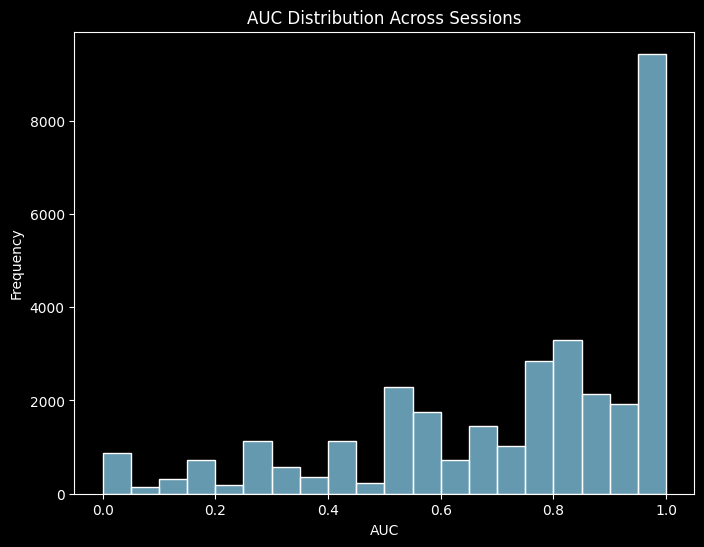

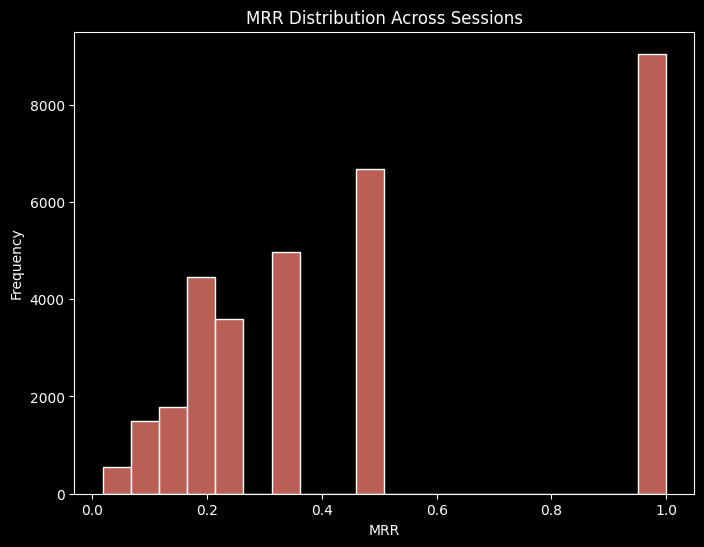

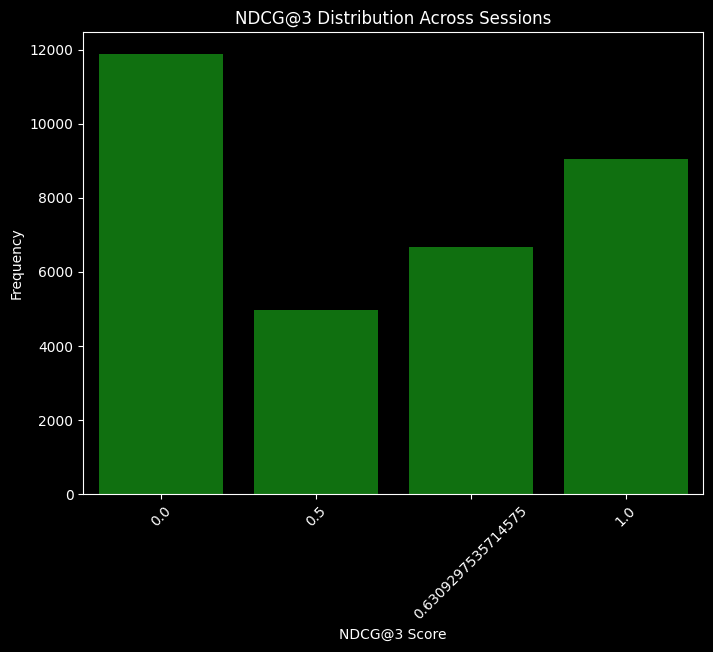

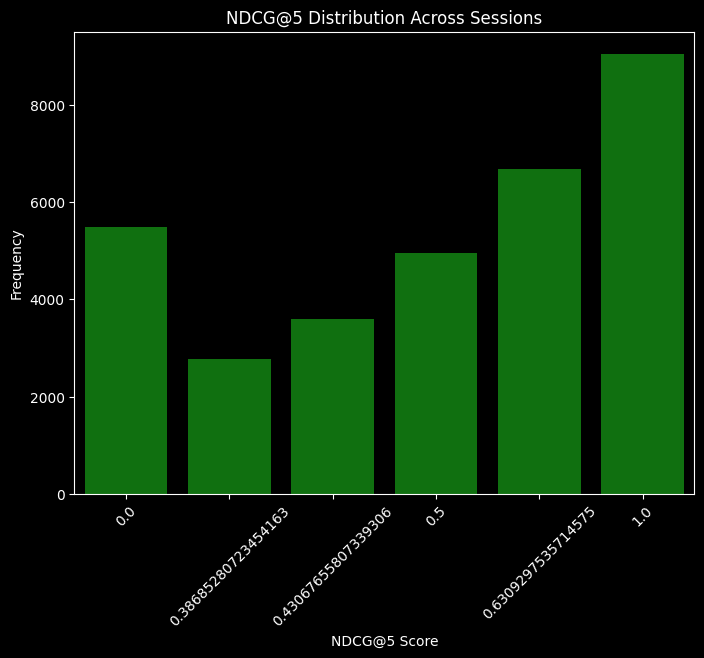

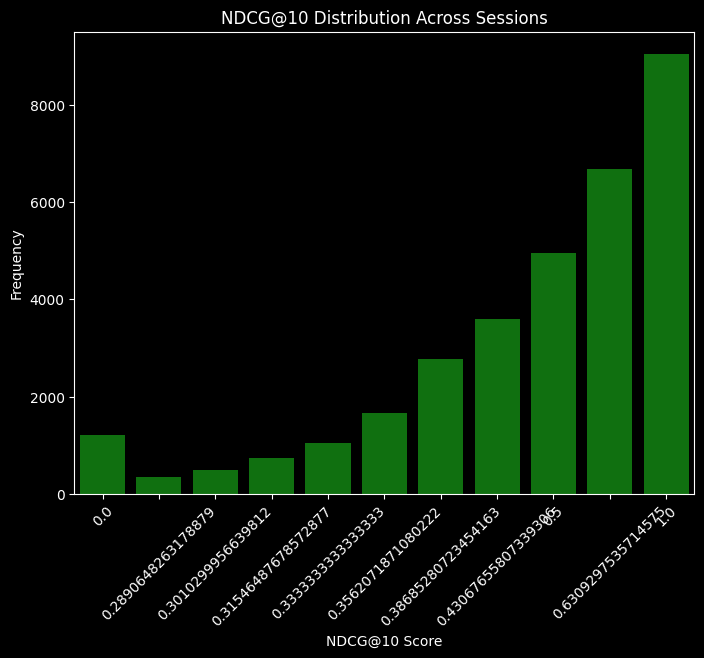

In [36]:

bins = 20
# Plot 2: AUC Distribution Across Sessions
plt.figure(figsize=(8, 6))
sns.histplot(results['AUC'], kde=False, color="skyblue", bins=bins)
plt.title("AUC Distribution Across Sessions")
plt.xlabel("AUC")
plt.ylabel("Frequency")
plt.show()

# Plot 3: MRR Distribution
plt.figure(figsize=(8, 6))
sns.histplot(results['MRR'], kde=False, color="salmon", bins=bins)
plt.title("MRR Distribution Across Sessions")
plt.xlabel("MRR")
plt.ylabel("Frequency")
plt.show()

# NDCG@3 Distribution as a Bar Plot
ndcg3_counts = results['NDCG@3'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
sns.barplot(x=ndcg3_counts.index, y=ndcg3_counts.values, color="green")
plt.title("NDCG@3 Distribution Across Sessions")
plt.xlabel("NDCG@3 Score")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

# NDCG@5 Distribution as a Bar Plot
ndcg5_counts = results['NDCG@5'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
sns.barplot(x=ndcg5_counts.index, y=ndcg5_counts.values, color="green")
plt.title("NDCG@5 Distribution Across Sessions")
plt.xlabel("NDCG@5 Score")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

# NDCG@10 Distribution as a Bar Plot
ndcg10_counts = results['NDCG@10'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
sns.barplot(x=ndcg10_counts.index, y=ndcg10_counts.values, color="green")
plt.title("NDCG@10 Distribution Across Sessions")
plt.xlabel("NDCG@10 Score")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()



